# FIT5196 Assessment 1 - EDA

Due Date: 23:55, Sunday, 14 September 2025


---



#### Group 35:
Member 1: Adrian Leong Tat Wei, (27030768), atleo4@student.monash.edu, Contribution

Member 2: Jun Yuan, (35833645), jyua0050@student.monash.edu, Contribution

Member 3: Low Xuan Nan (35373849), alow0028@student.monash.edu, Contribution

---

### Table of Content

1.
2.
3.



In [1]:
!pip install emoji
!pip install wordninja

## 1. Load, parse and merge data files






In [2]:
# from google.colab import drive
# import os

# print(os.listdir('.'))

# drive.mount('/content/drive')
# base = "./drive/MyDrive/FIT5196/Assignment1/" # for colab

In [3]:
# begin here if running locally
import pandas as pd
import re
import emoji

# for local drive
base = ""

### 1.1 Load data files

In [4]:
# https://docs.python.org/3/library/xml.etree.elementtree.html
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse(base + "Group035.xml")
root = tree.getroot()

# root is <FlickrData>, iterate over each <Record>
records = []
for record in root.findall("Record"):
    record_dict = {child.tag: child.text for child in record}
    records.append(record_dict)

print(type(records))   # <class 'list'>
print(records[0])      # print the first record

# Assuming records (from XML) is loaded as a list of dicts
df_xml = pd.DataFrame(records)


<class 'list'>
{'PostID': '49219111338.0', 'UserID': '124930081@N08', 'secret': '1187640507', 'server': '65535.0', 'title': 'DSC_0652 National Trust Museum (former Port Pirie Railway Station), 73-77 Ellen Street, Port Pirie, South Australia', 'ispublic': '1.0', 'isfriend': '0.0', 'isfamily': '0.0', 'farm': '66.0', 'City': 'Adelaide', 'Country': 'Australia', 'Post_date': '2019-12-14 22:49:28', 'Taken_date': '2019-09-18 13:15:16', 'tags': 'portpirie,museum,railwaystation,southaustralia,australia,architecture,heritage,historic,', 'latitude': '-33.175428', 'longitude': '138.010339', 'description': 'Port Pirie station was the original station in Port Pirie. It opened in 1875 when the Port Pirie-Cockburn line opened to Gladstone. The original building was replaced in 1902.\n\nState Heritage ID: 10229', 'min_taken_date': '2019-09-18 00:00:00'}


In [5]:
# https://www.geeksforgeeks.org/python/read-json-file-using-python/
import json

# Open and load the JSON file
with open(base + "Group035.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)

# json_data is now a list of dictionaries
print(type(json_data))  # <class 'list'>
print(json_data[0])     # print the first item

# Assuming json_data is loaded as a list of dicts
df_json = pd.DataFrame(json_data)

<class 'list'>
{'PostID': 51424269137.0, 'UserID': '73561613@N06', 'secret': '9aa2d9ed0e', 'server': 65535.0, 'title': 'Aerial view at the beach with waves', 'ispublic': 1.0, 'isfriend': 0.0, 'isfamily': 0.0, 'farm': 66.0, 'City': 'Woy Woy', 'Country': 'Australia', 'Post_date': '2021-09-05 01:22:55', 'Taken_date': '2021-08-26 09:29:57', 'tags': 'swell,landscape,winter,nature,water,sky,surf,windy,aerial,waves,newsouthwales,sea,uminabeach,morning,blue,beach,ocean,australia,coast,earlymorning,coastal,nsw,outdoors,waterscape,seascape,centralcoast,southerlyswell,seaside,', 'latitude': -33.527998, 'longitude': 151.315008, 'description': 'Southerly swell producing waves at Umina Beach on the Central Coast, NSW, Australia.', 'min_taken_date': '2021-08-26 00:00:00'}


### 1.2 Merge dataset

In [6]:
import numpy as np

def clean_text_content(text_input):
    """
    Clean text fields according to assignment specifications:
    - Convert to lowercase (except NaN)
    - Remove XML/JSON tags using regex
    - Remove emojis using emoji library
    - Remove non-English characters using regex
    - Replace null values with 'NaN'
    """
    if pd.isna(text_input) or text_input is None or str(text_input).strip() == '' or text_input == "null":
        return np.nan

    text_str = str(text_input)
    if text_str.lower() == 'nan':
        return np.nan

    text_str = text_str.lower()
    text_str = re.sub(r'<[^>]*>', '', text_str)
    text_str = re.sub(r'&[a-zA-Z0-9#]+;', '', text_str)
    text_str = emoji.replace_emoji(text_str, replace='')
    text_str = re.sub(r'[^a-zA-Z0-9\s.,!?;:()\-\'"/\\@#$%&*+=<>~`|{}[\]^]+', '', text_str)
    text_str = re.sub(r'\s+', ' ', text_str)
    text_str = text_str.strip()

    if len(text_str) == 0:
        return np.nan
    return text_str

def clean_tags(tags_input):
    """
    Specialized tag cleaning: tokenize by comma, drop empties
    """
    if pd.isna(tags_input) or tags_input is None or str(tags_input).strip() == '' or tags_input == "null":
        return np.nan

    text_str = str(tags_input)
    if text_str.lower() == 'nan':
        return np.nan

    cleaned_text = clean_text_content(tags_input)
    if pd.isna(cleaned_text):
        return np.nan

    tags = [tag.strip() for tag in cleaned_text.split(',')]
    tags = [tag for tag in tags if tag and tag != '']

    if not tags:
        return np.nan

    return ','.join(tags)

# Clean alphanumeric columns
alphanumeric_columns = ["UserID", "secret"]
for col in alphanumeric_columns:
    for dataframe in [df_json, df_xml]:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].apply(clean_text_content)

# Clean numeric columns
numeric_columns = ["PostID", "server", "ispublic", "isfriend", "isfamily", "farm", "latitude", "longitude"]
for col in numeric_columns:
    for dataframe in [df_json, df_xml]:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].apply(clean_text_content)
            dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')

# Clean datetime columns
datetime_columns = ["Post_date", "Taken_date", "min_taken_date"]
for col in datetime_columns:
    for dataframe in [df_json, df_xml]:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].apply(clean_text_content)
            dataframe[col] = pd.to_datetime(dataframe[col], errors='coerce')

# Clean text columns (Member B focus)
text_columns = ["title", "description", "City", "Country"]
for col in text_columns:
    for dataframe in [df_json, df_xml]:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].apply(clean_text_content)

# Clean tags with specialized processing
for dataframe in [df_json, df_xml]:
    if "tags" in dataframe.columns:
        dataframe["tags"] = dataframe["tags"].apply(clean_tags)

# Merge datasets
df_all = pd.concat([df_json, df_xml], ignore_index=True)

print(f"Dataset merged successfully: {len(df_all)} records, {len(df_all.columns)} columns")

Dataset merged successfully: 70000 records, 18 columns


In [7]:
import re
import wordninja

def rename_column(colname: str) -> str:
    """
    Convert column names into Title_Case with underscores.
    Handles camelCase, PascalCase, acronyms, and concatenated words.
    """
    # Step 1: Split camelCase / PascalCase into separate words
    # e.g. UserID -> ['User', 'ID'], isPublic -> ['is', 'Public']
    camel_split = re.sub(r'([a-z])([A-Z])', r'\1 \2', colname)

    # Step 2: Split on underscores (already separated words)
    tokens = re.split(r'[_\s]+', camel_split)

    final_tokens = []
    for token in tokens:
        if not token:
            continue
        # Step 3: Preserve acronyms (all caps, length > 1)
        if token.isupper() and len(token) > 1:
            final_tokens.append(token)
        else:
            # Step 4: Word segmentation for lowercase tokens
            if token.islower():
                split_words = wordninja.split(token)
            else:
                split_words = [token]
            # Step 5: Capitalize first letter of each segment
            final_tokens.extend([w.capitalize() for w in split_words])

    # Step 6: Join with underscores
    return "_".join(final_tokens)

# Example usage on your dataframe:
df_all.rename(columns=lambda c: rename_column(c), inplace=True)

print(df_all.columns)

Index(['Post_ID', 'User_ID', 'Secret', 'Server', 'Title', 'Is_Public',
       'Is_Friend', 'Is_Family', 'Farm', 'City', 'Country', 'Post_Date',
       'Taken_Date', 'Tags', 'Latitude', 'Longitude', 'Description',
       'Min_Taken_Date'],
      dtype='object')


In [8]:
df_all.to_csv('Group035_dataset.csv', index=False, na_rep="NaN")

## 2. EDA

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Configure plotting settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

print("EDA libraries loaded successfully")

EDA libraries loaded successfully


### 2.1 Dataset overview

In [10]:
print("Dataset Structure and Dimensions")
print("=" * 40)

# Basic dataset information
print(f"Total number of records: {len(df_all)}")
print(f"Number of attributes: {len(df_all.columns)}")
print(f"Dataset shape: {df_all.shape}")

# Column information
summary = (
    pd.DataFrame({
        "Non-Null Count": df_all.count(),
        "Distinct Count": df_all.nunique()
    })
    .reset_index()
    .rename(columns={"index": "Column"})
    .set_index(pd.Index(range(1, len(df_all.columns)+1)))
)

print(summary.to_string(index=True, index_names=False))
# print(f"\nColumn names:")
# for i, col in enumerate(df_all.columns, 1):
#     print(f"{i:2d}. {col}")

# Memory usage
memory_usage = df_all.memory_usage(deep=True).sum() / 1024 / 1024
print(f"\nTotal memory usage: {memory_usage:.2f} MB")

# Data types summary
print(f"\nData types summary:")
dtype_counts = df_all.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"  {dtype}: {count} columns")

print("\nFirst 5 records:")
print(df_all.head())

Dataset Structure and Dimensions
Total number of records: 70000
Number of attributes: 18
Dataset shape: (70000, 18)
            Column  Non-Null Count  Distinct Count
1          Post_ID           69156           64746
2          User_ID           69156            3178
3           Secret           69156           64745
4           Server           69156             931
5            Title           66470           53095
6        Is_Public           69156               1
7        Is_Friend           69156               1
8        Is_Family           69156               1
9             Farm           69156              10
10            City           35773             622
11         Country           37578             121
12       Post_Date           70000           64004
13      Taken_Date           69156           64306
14            Tags           46031           26757
15        Latitude           69156           45749
16       Longitude           69156           44887
17     Descriptio

### 2.2 Univariate analysis

The count of distinct values in access fields Is_Family, Is_Friend, Is_Public show that the collected data is unanimously Is_Public.
This makes sense, because it simply means that the dataset was collected from public data, 
so naturally, data which had Is_Family and Is_Friend tags simply could not be collected.
```python
print(max(df_all['Is_Family'])) # 0
print(max(df_all['Is_Friend'])) # 0 
print(min(df_all['Is_Public'])) # 1
```
We also see that most, but not all, of Post_ID and Secret are distinct. This likely means there are some duplicate data.

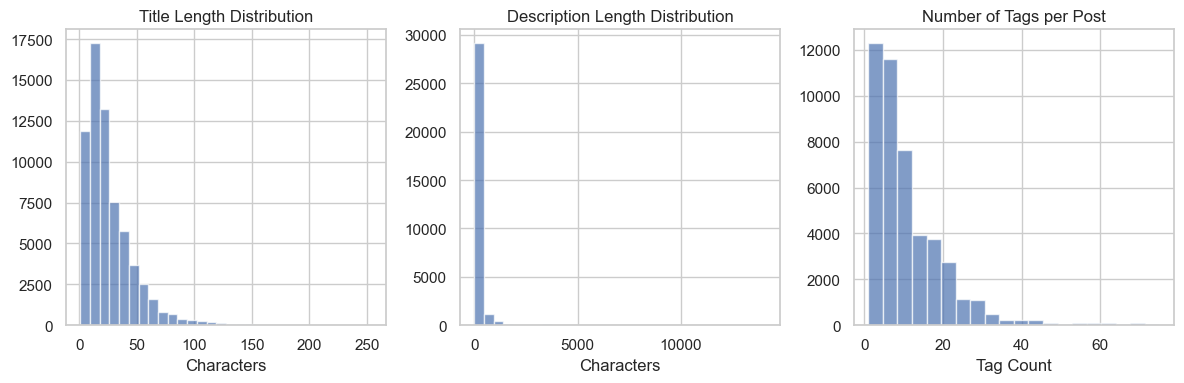

In [19]:
# Text length distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
title_lengths = df_all['Title'].dropna().str.len()
plt.hist(title_lengths, bins=30, alpha=0.7)
plt.title('Title Length Distribution')
plt.xlabel('Characters')

plt.subplot(1, 3, 2)
desc_lengths = df_all['Description'].dropna().str.len()
plt.hist(desc_lengths, bins=30, alpha=0.7)
plt.title('Description Length Distribution')
plt.xlabel('Characters')

plt.subplot(1, 3, 3)
tag_counts = df_all['Tags'].dropna().apply(lambda x: len(x.split(',')))
plt.hist(tag_counts, bins=20, alpha=0.7)
plt.title('Number of Tags per Post')
plt.xlabel('Tag Count')

plt.tight_layout()
plt.show()

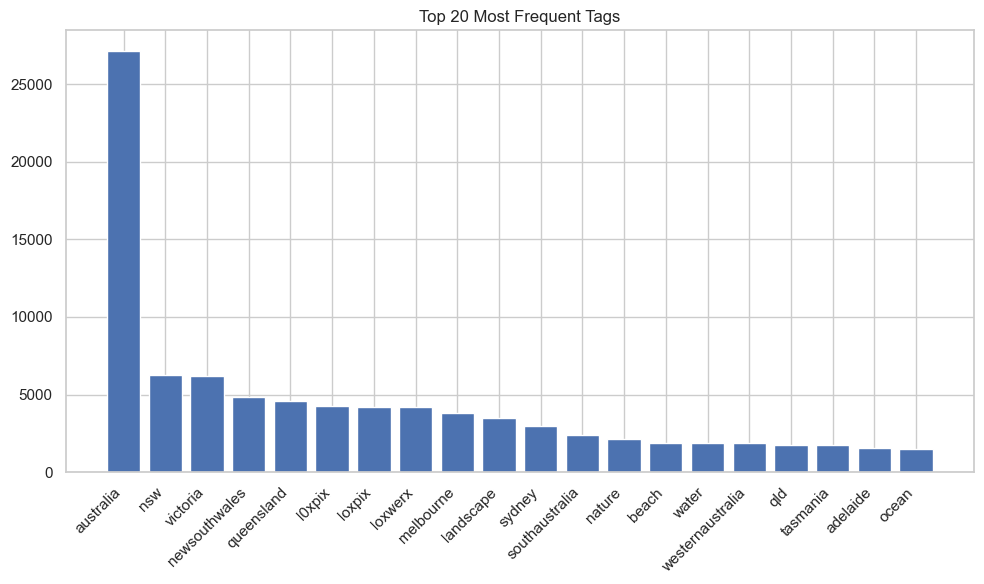

Total unique tags: 49536
Posts with tags: 46031 / 70000


In [20]:
# Tag analysis
all_tags = []
for tags_str in df_all['Tags'].dropna():
    all_tags.extend(tags_str.split(','))

tag_freq = Counter(all_tags).most_common(20)

# Plot top tags
plt.figure(figsize=(10, 6))
tags_list, counts_list = zip(*tag_freq)
plt.bar(tags_list, counts_list)
plt.title('Top 20 Most Frequent Tags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Total unique tags: {len(set(all_tags))}")
print(f"Posts with tags: {df_all['Tags'].notna().sum()} / {len(df_all)}")

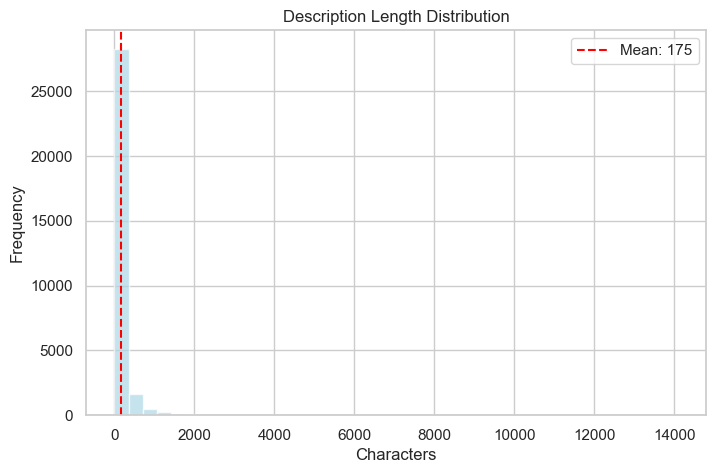

description statistics: mean=175, max=14100


In [21]:
# description length distributions
desc_lengths = df_all['Description'].dropna().str.len()

plt.figure(figsize=(8, 5))
plt.hist(desc_lengths, bins=40, alpha=0.7, color='lightblue')
plt.title('Description Length Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.axvline(desc_lengths.mean(), color='red', linestyle='--', label=f'Mean: {desc_lengths.mean():.0f}')
plt.legend()
plt.show()

print(f"description statistics: mean={desc_lengths.mean():.0f}, max={desc_lengths.max()}")

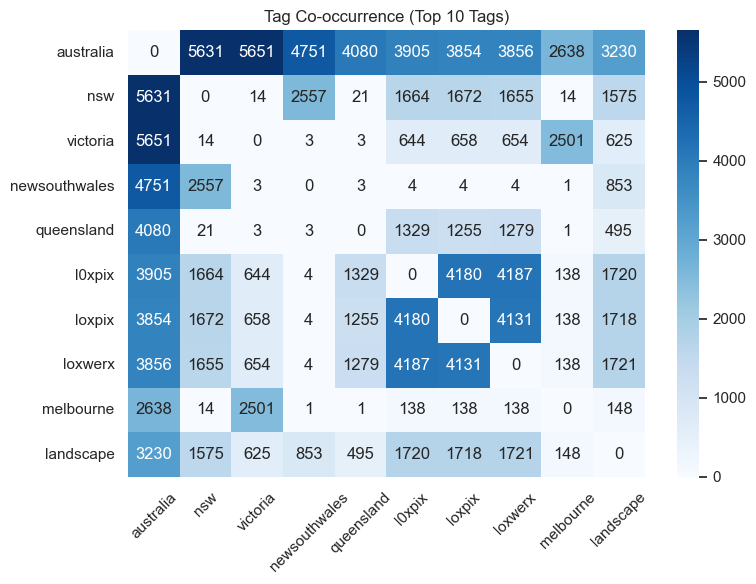

most common tag combinations:
australia + nsw: 5631 times
australia + victoria: 5651 times
australia + newsouthwales: 4751 times
australia + queensland: 4080 times
australia + l0xpix: 3905 times
australia + loxpix: 3854 times
australia + loxwerx: 3856 times
australia + melbourne: 2638 times
australia + landscape: 3230 times
nsw + newsouthwales: 2557 times
nsw + l0xpix: 1664 times
nsw + loxpix: 1672 times
nsw + loxwerx: 1655 times
nsw + landscape: 1575 times
victoria + l0xpix: 644 times
victoria + loxpix: 658 times
victoria + loxwerx: 654 times
victoria + melbourne: 2501 times
victoria + landscape: 625 times
newsouthwales + landscape: 853 times
queensland + l0xpix: 1329 times
queensland + loxpix: 1255 times
queensland + loxwerx: 1279 times
queensland + landscape: 495 times
l0xpix + loxpix: 4180 times
l0xpix + loxwerx: 4187 times
l0xpix + melbourne: 138 times
l0xpix + landscape: 1720 times
loxpix + loxwerx: 4131 times
loxpix + melbourne: 138 times
loxpix + landscape: 1718 times
loxwerx +

In [22]:
# tag co-occurrence analysis
# get top tags first
all_tags = []
for tags in df_all['Tags'].dropna():
    all_tags.extend(tags.split(','))

top_tags = [tag for tag, count in Counter(all_tags).most_common(10)]

# build co-occurrence matrix
import numpy as np
cooc = np.zeros((10, 10))

for tags in df_all['Tags'].dropna():
    tag_list = tags.split(',')
    for i, tag1 in enumerate(top_tags):
        for j, tag2 in enumerate(top_tags):
            if tag1 in tag_list and tag2 in tag_list and i != j:
                cooc[i][j] += 1

# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cooc, xticklabels=top_tags, yticklabels=top_tags,
            annot=True, fmt='.0f', cmap='Blues')
plt.title('Tag Co-occurrence (Top 10 Tags)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("most common tag combinations:")
for i in range(len(top_tags)):
    for j in range(i+1, len(top_tags)):
        if cooc[i][j] > 50:  # only show frequent combinations
            print(f"{top_tags[i]} + {top_tags[j]}: {int(cooc[i][j])} times")

### 2.3 Bivariate analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def bucketize(n):
    if n == 1:
        return "1"
    elif 2 <= n <= 5:
        return "2-5"
    elif 6 <= n <= 10:
        return "6-10"
    elif 11 <= n <= 50:
        return "11-50"
    elif 51 <= n <= 100:
        return "51-100"
    elif 101 <= n <= 1000:
        return "101-1000"
    else:
        return "1001+"
# Order by magnitude
bucket_order = ["1", "2-5", "6-10", "11-50", "51-100", "101-1000", "1001+"]

# 1. Posts per user
posts_per_user = df_all.groupby("User_ID")["Post_ID"].count()
posts_per_user_bucketed = posts_per_user.map(bucketize).value_counts()
posts_per_user_bucketed = posts_per_user_bucketed.reindex(bucket_order).dropna()

# 2. Posts per server
posts_per_server = df_all.groupby("Server")["Post_ID"].count()
posts_per_server_bucketed = posts_per_server.map(bucketize).value_counts()
posts_per_server_bucketed = posts_per_server_bucketed.reindex(bucket_order).dropna()

# 3. Posts per farm (non-bucketed)
posts_per_farm = df_all.groupby("Farm")["Post_ID"].count()

# 4. Users per server
users_per_server = df_all.groupby("Server")["User_ID"].nunique()
users_per_server_bucketed = users_per_server.map(bucketize).value_counts()
users_per_server_bucketed = users_per_server_bucketed.reindex(bucket_order).dropna()

# 5. Users per farm (non-bucketed)
users_per_farm = df_all.groupby("Farm")["User_ID"].nunique()

# Plot in subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

def plot_series(ax, series, title, xlabel, ylabel, logy=True):
    series.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logy:
        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_ylim(1, 100000)

# 1. Posts per user
plot_series(axes[0], posts_per_user_bucketed, "Distribution of Users by Posts Made", "Posts per User (bucketed)", "Number of Users")

# 2. Posts per server
plot_series(axes[1], posts_per_server_bucketed, "Distribution of Servers by Posts Received", "Posts per Server (bucketed)", "Number of Servers")

# 3. Users per server
plot_series(axes[2], users_per_server_bucketed, "Distribution of Servers by User Count", "Users per Server (bucketed)", "Number of Servers")

# 4. Posts per farm (non-bucketed, alphabetical order OK)
plot_series(axes[3], posts_per_farm, "Posts per Farm", "Farm", "Number of Posts")

# 5. Users per farm (non-bucketed)
plot_series(axes[4], users_per_farm, "Users per Farm", "Farm", "Number of Users")

# Remove unused subplot (bottom right)
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()



### 2.4 Multivariate analysis

## 3. Key insights and research questions



### 3.1 Key findings

- **Data completeness:** 95.0% posts have titles, 44.5% have descriptions, 65.8% have tags
- **Text characteristics:** Average 27 chars per title, 175 chars per description, 11 tags per post  
- **Popular topics:** Australia, landscape, melbourne, nature, nsw are most frequent tags
- **Tag patterns:** Strong co-occurrence between location and nature tags observed

In [23]:
# analyze tag patterns for ML categories
nature_tags = ['landscape', 'nature', 'outdoor', 'beach', 'water', 'sky']
urban_tags = ['city', 'urban', 'melbourne', 'architecture', 'street']
australia_tags = ['australia', 'nsw', 'victoria', 'queensland']

nature_posts = sum(1 for tags_str in df_all['Tags'].dropna()
                   if any(tag in nature_tags for tag in tags_str.split(',')))
urban_posts = sum(1 for tags_str in df_all['Tags'].dropna()
                  if any(tag in urban_tags for tag in tags_str.split(',')))
australia_posts = sum(1 for tags_str in df_all['Tags'].dropna()
                      if any(tag in australia_tags for tag in tags_str.split(',')))

print(f"nature posts: {nature_posts:,}")
print(f"urban posts: {urban_posts:,}")
print(f"australia posts: {australia_posts:,}")
print(f"posts with title+tags: {df_all[['Title','Tags']].dropna().shape[0]:,}")

nature posts: 7,096
urban posts: 5,477
australia posts: 28,718
posts with title+tags: 44,938


### 3.2 Machine Learning research questions and justification

**Question 1:** Can we predict post categories from title and description text?

From looking at the tags, I noticed that different types of posts have different tag patterns. Nature photos usually have tags like 'landscape', 'outdoor', 'beach', while city photos have 'city', 'melbourne', 'architecture'. Since most posts have titles (95%) and the tag patterns are quite different, we could probably train a model to predict the category by analyzing the words in titles and descriptions. The TF-IDF method could work well here to find important words for each category.

**Question 2:** Can we group similar posts together using their tags?

Since each post has about 11 tags on average, there's lots of information to compare posts. When I looked at the data, posts about similar topics tend to share many tags - like landscape photos often have 'nature', 'outdoor', 'australia' together. We could measure how similar two posts are by counting how many tags they share (Jaccard similarity) and then use clustering algorithms like K-means to group them. The co-occurrence analysis already shows that some tags naturally go together, which makes clustering possible.

## Reference

After you run the cell above and authorize Google Drive access, your Drive will be mounted at `/content/drive`. You can then access your files using the path `/content/drive/MyDrive/your_folder_name/your_file_name`.

Now, I'll update the code cells to load the XML and JSON files from your Google Drive. **Please update the file paths in the code cells below to the correct location of your files in Google Drive.**